Please read **carefully** the explanations written between the code cells. Edit or add your own code when you see `#####` symbols.

### Setup

`tamaas` should already be installed from last week session. But if that is not the case, run the cell bellow (clic on it and press `shift+enter`), and when the installation is finished ('`Successfully installed ...`'), restart the Python kernel from the menu: `Kernel > Restart`.

In [1]:
!pip install --user --no-warn-script-location tamaas==2.3.0.post1

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


We import the usual libraries.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # to make 3d plots
import tamaas as tm
tm.initialize()

# Rough contact mechanics

Tamaas is made for solving the contact between a rigid surface having a given shape (near to flat) and a flat elastic surface, knowing the total applied normal load or **normal pressure** $p_\text{N}$. You will generate some rough surfaces, solve for the contact, and look at the **real contact area** $A$ between the two contacting surfaces, which is **a fraction** of the total surface area $A_0 = L^2$.

## Definition of some functions (run but don't edit)

In [3]:
def gen_surf(L, n, l_smallest, l_largest, dh_RMS, Hurst, seed=1):
    # Create PSD object
    spectrum = tm.Isopowerlaw2D()

    # Set spectrum parameters
    spectrum.q0 = round(L / l_largest) # round: must be integers
    spectrum.q1 = round(L / l_largest) # q1 is the "roll-off" frequency, usually equal to q0
    spectrum.q2 = round(L / l_smallest)
    spectrum.hurst = Hurst

    # Create surface generator
    generator = tm.SurfaceGeneratorFilter2D([n, n])
    generator.spectrum = spectrum
    generator.random_seed = seed

    # Generate surface
    h = generator.buildSurface()
    h *= dh_RMS / tm.Statistics2D.computeSpectralRMSSlope(h) * L
    
    x = np.linspace(-L/2, L/2, n)
    y = x.copy()
    x, y = np.meshgrid(x, y, indexing="ij")
    
    return x, y, h


def plot_surf(x, y, h):
    fig = plt.figure(figsize=(5, 5), dpi=120)
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(x, y, h, rstride=1, cstride=1, cmap=plt.cm.inferno)

    z_ratio = 0.2
    ax.set_zlim([-L/2 * z_ratio, L/2 * z_ratio])
    ax.set_box_aspect([1, 1, z_ratio])
    plt.locator_params(axis="z", nbins=2) # reduce number of ticks on z axis

    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$h$")
    
    plt.show()

import sys, os
sys.stderr = open(os.devnull, "w") # To get rid of Tamaas console output


def solve(h, pressure):
    model = tm.ModelFactory.createModel(tm.model_type.basic_2d, [L, L], [n, n])
    model.E = E
    model.nu = nu
    solver = tm.PolonskyKeerRey(model, h, 1e-12)
    solver.solve(pressure)
    u = model.displacement.copy()
    p = model.traction.copy()
    return u, p


def plot_field(x, y, f, title=""):
    plt.figure(figsize=(3.65, 3), dpi=120)
    plt.pcolormesh(x, y, f, cmap=plt.cm.inferno, shading="gouraud")
    plt.colorbar()
    plt.axis("equal")
    
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    
    if title != "":
        plt.title(title)
    
    plt.show()

    
def comp_area_ratio(p):
    return np.sum(p > 0) / p.size

## Playground

We start by defining the geometric and physical parameters of our model. The values below can be kept as is.

In [4]:
# Surface geometry
L = 1                  # side length
n = 256                # number of points (discretization)
l_smallest = L / (n/2) # smallest wavelength (not smaller than L/n)
l_largest  = L / 2     # largest wavelength
Hurst = 0.8

# Physical parameters
E  = 1.0               # Young's modulus
nu = 0.3               # Poisson's ratio
Es = E / (1 - nu**2)   # Normalized Young's modulus

Next, we can generate some rough surfaces. One important parameter is the **RMS** (root mean square) **of the slopes** (derivative of the height distribution) $h'_\text{RMS} = \sqrt{\langle |\nabla h|^2\rangle}$. Change this parameter and see how it affects the resulting rough surface.

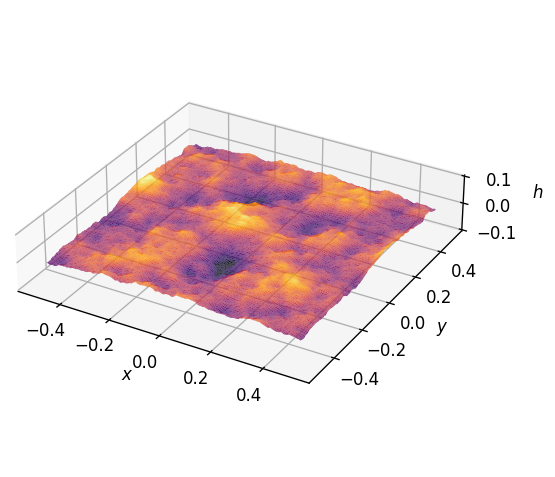

In [5]:
dh_RMS = 0.5 # CHANGE THIS VALUE ###############################################

x, y, h = gen_surf(L, n, l_smallest, l_largest, dh_RMS, Hurst)
plot_surf(x, y, h)

With the defined rough surface, we can solve for the contact for a given normal pressure $p_\text{N}$. As a result, we can look at the deformation of the elastic surface and at the local pressures. We can also see which parts of the two surfaces are in contact by searching where the local pressure is non-zero.

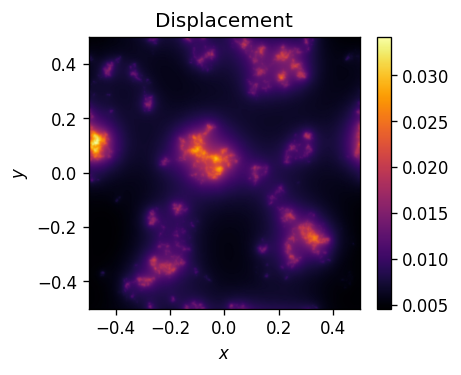

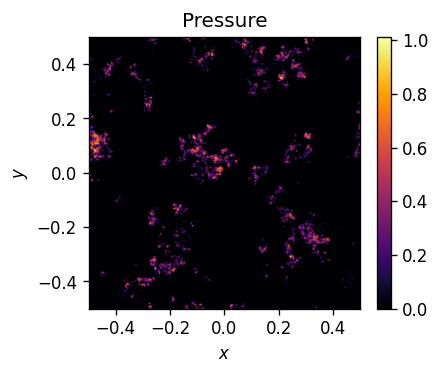

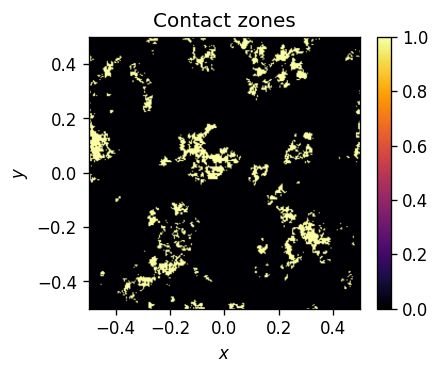

In [6]:
pressure = 2e-2 # CHANGE THIS VALUE ############################################

u, p = solve(h, pressure)
plot_field(x, y, u, "Displacement")
plot_field(x, y, p, "Pressure")
plot_field(x, y, p > 0, "Contact zones")

Finally, from the map of the contact zones, we can deduce the fraction of real contact area $A / A_0$.

In [7]:
print("Fraction of area in contact: {:.2f}%".format(comp_area_ratio(p) * 100))

Fraction of area in contact: 8.58%


## Fraction of area in contact

The fraction of area in contact depends on several parameters. Let's see which ones affect this quantity and how.

### Effect of normal pressure

We can run a loop with several values for the normal pressure and record the resulting area ratio. Choose a list of normal pressures to be tested and try to measure a wide range of area ratio, going from 0.1% to 100%.

In [8]:
dh_RMS = 0.5 # CHOOSE A FIXED VALUE FOR h'RMS ##################################
_, _, h = gen_surf(L, n, l_smallest, l_largest, dh_RMS, Hurst)

pressure_list = np.logspace(-3, 0, 7) # [0.001, 0.003, 0.01, ..., 1] # CREATE A LIST OF VALUES FOR THE PRESSURE
area_list_1 = []

for pressure_i in pressure_list:
    _, p = solve(h, pressure_i)
    area = comp_area_ratio(p)
    area_list_1.append(area)
    print("pN = {:.2e}, A/A0 = {:.2f}%".format(pressure_i, area * 100))

pN = 1.00e-03, A/A0 = 0.43%
pN = 3.16e-03, A/A0 = 1.49%
pN = 1.00e-02, A/A0 = 4.43%
pN = 3.16e-02, A/A0 = 13.23%
pN = 1.00e-01, A/A0 = 36.94%
pN = 3.16e-01, A/A0 = 82.18%
pN = 1.00e+00, A/A0 = 99.99%


Now look at a logarithmic plot of $A/A_0$ versus $p_\text{N}/E^*$. Find the slope of the curve for smaller values of $A/A_0$ (under 0.1, or 10%). Can you state a law for the evolution of $A/A_0$ as a function of $p_\text{N}/E^*$?

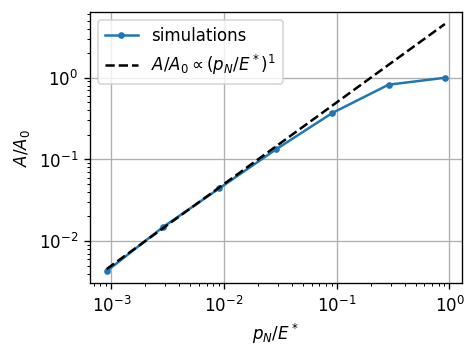

In [9]:
# FIND THE RIGHT FACTOR AND SLOPE ##############################################
factor = 2.5
slope  = 1
################################################################################

plt.figure(figsize=(4, 3), dpi=120)
plt.loglog(pressure_list / Es, area_list_1 ,".-", label="simulations")
plt.loglog(pressure_list / Es, factor * (pressure_list / Es)**slope / dh_RMS, "k--", label="$A/A_0 \propto (p_N/E^*)^{" + str(slope) + "}$")

plt.xlabel("$p_N/E^*$")
plt.ylabel("$A/A_0$")
plt.legend()
plt.grid()

plt.show()

### Effect of roughness

Now, do the same process but by varying the roughness of the rigid surface. Choose a list of $h'_\text{RMS}$ to be tested and try to measure a wide range of area ratio, going from 0.1% to 100%.

In [10]:
pressure = 2e-3 # CHOOSE A FIXED VALUE FOR THE PRESSURE ###########################

dh_RMS_list = np.logspace(-3, 0, 7) # [0.001, 0.003, 0.01, ..., 1] # CREATE A LIST OF VALUES FOR h'RMS
area_list_2 = []

for dh_RMS_i in dh_RMS_list:
    _, _, h = gen_surf(L, n, l_smallest, l_largest, dh_RMS_i, Hurst)
    _, p = solve(h, pressure)
    area = comp_area_ratio(p)
    area_list_2.append(area)
    print("h'RMS = {:.2e}, A/A0 = {:.2f}%".format(dh_RMS_i, area * 100))

h'RMS = 1.00e-03, A/A0 = 99.99%
h'RMS = 3.16e-03, A/A0 = 82.18%
h'RMS = 1.00e-02, A/A0 = 36.94%
h'RMS = 3.16e-02, A/A0 = 13.23%
h'RMS = 1.00e-01, A/A0 = 4.43%
h'RMS = 3.16e-01, A/A0 = 1.49%
h'RMS = 1.00e+00, A/A0 = 0.43%


Again, look at a logarithmic plot of $A/A_0$ versus $h'_\text{RMS}$ and find a relation between the two.

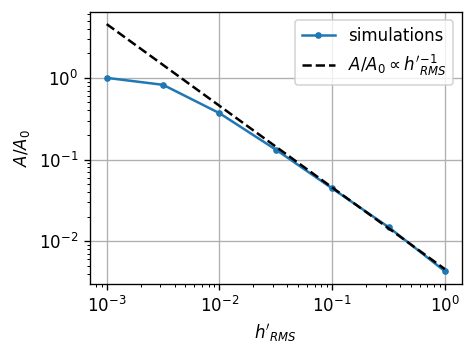

In [11]:
# FIND THE RIGHT FACTOR AND SLOPE ##############################################
factor = 2.5
slope  = -1
################################################################################

plt.figure(figsize=(4, 3), dpi=120)
plt.loglog(dh_RMS_list, area_list_2 ,".-", label="simulations")
plt.loglog(dh_RMS_list, factor * pressure * dh_RMS_list**slope / Es, "k--", label="$A/A_0 \propto h'_{RMS}^{" + str(slope) + "}$")

plt.xlabel("$h'_{RMS}$")
plt.ylabel("$A/A_0$")
plt.legend()
plt.grid()

plt.show()

### Theory

From the two power laws you found above, come up with a theoretical estimate for the ratio $A/A_0$ as a function of $p_\text{N}/E^*$ and $h'_\text{RMS}$ and see if it maches the simultions for small values of $A/A_0$ (under 0.1).

In [12]:
def area_ratio_theory(pressure, dh_RMS):
    return np.sqrt(2 * np.pi) * pressure / (dh_RMS * Es) # DEFINE THE THEORETICAL CONTACT AREA RATIO
    # sqrt(2 * pi) ≈ 2.5

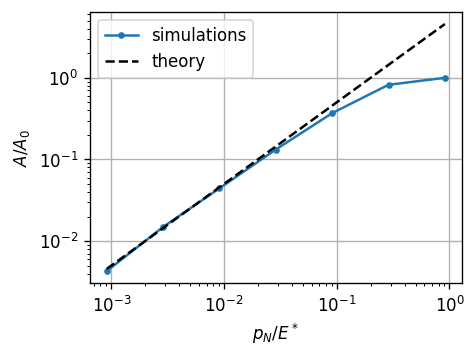

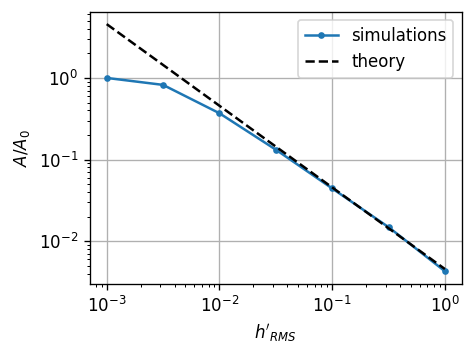

In [13]:
# Varying pressure
plt.figure(figsize=(4, 3), dpi=120)
plt.loglog(pressure_list / Es, area_list_1 ,".-", label="simulations")
plt.loglog(pressure_list / Es, area_ratio_theory(pressure_list, dh_RMS), "k--", label="theory")

plt.xlabel("$p_N/E^*$")
plt.ylabel("$A/A_0$")
plt.legend()
plt.grid()

plt.show()

# Varying h'RMS
plt.figure(figsize=(4, 3), dpi=120)
plt.loglog(dh_RMS_list, area_list_2 ,".-", label="simulations")
plt.loglog(dh_RMS_list, area_ratio_theory(pressure, dh_RMS_list), "k--", label="theory")

plt.xlabel("$h'_{RMS}$")
plt.ylabel("$A/A_0$")
plt.legend()
plt.grid()

plt.show()